## Check GPU presence

In [1]:
import sys
print(sys.executable)
print(sys.version)

#import sys
#!{sys.executable} -m pip uninstall torch torchvision torchaudio -y
#!{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

import torch
import torchvision

print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

C:\Users\aaron\AppData\Local\Programs\Python\Python311\python.exe
3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
PyTorch: 2.5.1+cu121
Torchvision: 0.20.1+cu121
CUDA available: True


In [2]:
from torch.utils.data import Dataset

# Custom Dataset class
class ChipDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Add dtype=torch.long
        return image, label

!pip install --upgrade pip --quiet


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\Users\aaron\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip --quiet


## Collect / analyze image database

Collect all images in the database, count the number of samples in each brand, and present in a plot. For this model, each model must have a minimum of 20 images to be used.

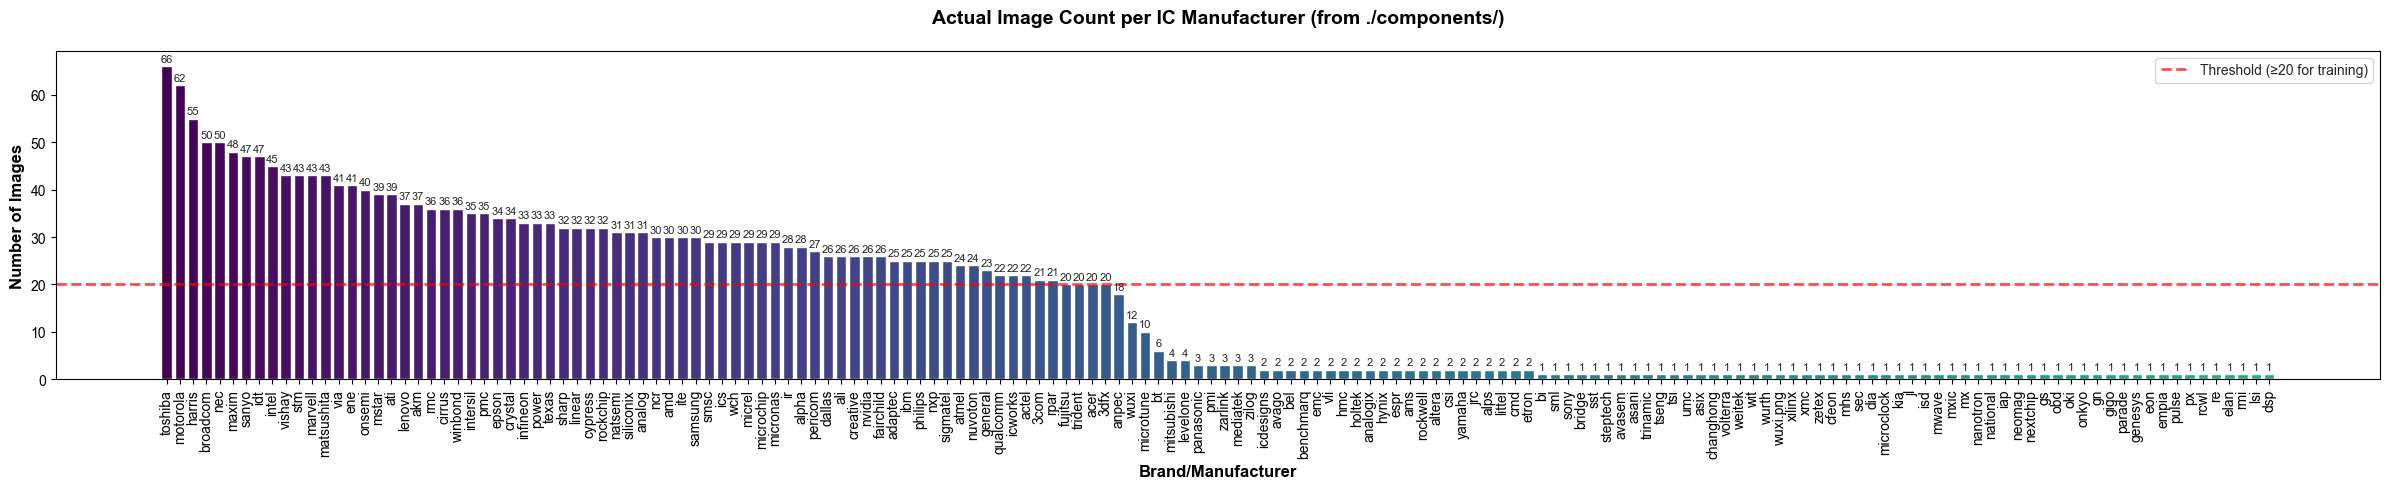

In [3]:
# Section 1: Data Augmentation & Dataset Setup
import os
from PIL import Image
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Define your data directory
DATA_DIR = './components/'

# Scan the directory and build the dataset directly from files
brand_counts = Counter()
all_files = []

for filename in os.listdir(DATA_DIR):
    if filename.endswith('.png'):
        brand = filename.split('_')[0]
        brand_counts[brand] += 1
        all_files.append(filename)

# Create dataframe from actual files
df = pd.DataFrame([
    {'Brand': brand, 'Moniker': brand, 'Count': count}
    for brand, count in brand_counts.items()
]).sort_values('Count', ascending=False)

# Create visualization
fig, ax = plt.subplots(figsize=(24, 5))
sns.set_style("whitegrid")

# Create bar plot using matplotlib directly for better control
x_positions = range(len(df))
bars = ax.bar(x_positions, df['Count'], color=plt.cm.viridis(range(len(df))))

# Customize the plot
ax.set_xticks(x_positions)
ax.set_xticklabels(df['Brand'], rotation=90, ha='center')  # Changed to ha='center'
ax.set_xlabel('Brand/Manufacturer', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax.set_title('Actual Image Count per IC Manufacturer (from ./components/)', fontsize=14, fontweight='bold', pad=20)

# Add value labels on top of bars
for i, (pos, count) in enumerate(zip(x_positions, df['Count'])):
    ax.text(pos, count + 0.5, str(count), ha='center', va='bottom', fontsize=8)

# Add threshold line
ax.axhline(y=20, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Threshold (≥20 for training)')
ax.legend()

plt.tight_layout()
plt.show()

# Filter to brands with >= 20 images
min_df = df[df['Count'] >= 20].copy()

# Get list of valid brands (these will be your classes)
valid_brands = min_df['Moniker'].tolist()
brand_to_idx = {brand: idx for idx, brand in enumerate(sorted(valid_brands))}
idx_to_brand = {idx: brand for brand, idx in brand_to_idx.items()}

# Collect all valid images (only from brands with >= 20 images)
image_paths = []
labels = []

for filename in all_files:
    brand = filename.split('_')[0]
    
    if brand in brand_to_idx:
        image_paths.append(os.path.join(DATA_DIR, filename))
        labels.append(brand_to_idx[brand])

## Reduce dataset to minimum viable brands

To be used in the model, each brand must contain a minimum of 20 samples. Brands with less than 20 samples are discarded from the dataset.

In [4]:
# Section 3: Download/Build the Model
import torch.nn as nn
from torchvision import models

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# Load pretrained ResNet-18
print(f"\n{'='*60}")
print("Loading ResNet-18 with ImageNet pretrained weights...")

model = models.resnet18(pretrained=True)

# Freeze early layers (optional - keeps ImageNet features)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_classes = len(brand_to_idx)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to GPU/CPU
model = model.to(device)

print(f"Model architecture modified:")
print(f"  Original output: 1000 classes (ImageNet)")
print(f"  New output: {num_classes} classes (IC brands)")
print(f"  Frozen layers: Early conv layers (transfer learning)")
print(f"  Trainable layers: Final FC layer")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel parameters:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Frozen parameters: {total_params - trainable_params:,}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

print(f"\nTraining configuration:")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")
print(f"\nModel ready for training!")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memory: 6.00 GB

Loading ResNet-18 with ImageNet pretrained weights...


C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model architecture modified:
  Original output: 1000 classes (ImageNet)
  New output: 72 classes (IC brands)
  Frozen layers: Early conv layers (transfer learning)
  Trainable layers: Final FC layer

Model parameters:
  Total parameters: 11,213,448
  Trainable parameters: 36,936
  Frozen parameters: 11,176,512

Training configuration:
  Loss function: CrossEntropyLoss
  Optimizer: Adam (lr=0.001)
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)

Model ready for training!


C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Split dataset into train / test / validation (80 / (80/20))

In [5]:
# Section 2: Train/Test/Validation Split with Balanced Sampling
from sklearn.model_selection import train_test_split
import numpy as np
from torchvision import transforms
from torch.utils.data import WeightedRandomSampler

# Convert to numpy arrays for easier manipulation
image_paths = np.array(image_paths)  # FIXED: No dtype for strings
labels = np.array(labels, dtype=np.int64)

print(f"Total dataset: {len(image_paths)} images")
print(f"Number of classes: {len(brand_to_idx)}")

# First split: 80% train+val, 20% test
# Stratify to ensure each brand is represented proportionally in each split
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, 
    labels, 
    test_size=0.2,  # 20% for test
    stratify=labels,  # Maintain class distribution
    random_state=42
)

# Second split: Split train+val into 80% train, 20% val
# From the remaining 80%, take 20% for validation (which is 16% of total)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths,
    train_val_labels,
    test_size=0.2,  # 20% of train_val = 16% of total
    stratify=train_val_labels,
    random_state=42
)

# Final split: ~64% train, ~16% val, ~20% test
print(f"\n{'='*60}")
print(f"Split Summary:")
print(f"  Training:   {len(train_paths)} images ({len(train_paths)/len(image_paths)*100:.1f}%)")
print(f"  Validation: {len(val_paths)} images ({len(val_paths)/len(image_paths)*100:.1f}%)")
print(f"  Test:       {len(test_paths)} images ({len(test_paths)/len(image_paths)*100:.1f}%)")

# Calculate class weights for balanced sampling
print(f"\n{'='*60}")
print("Setting up balanced sampling for training...")
print(f"{'='*60}")

# Count samples per class in training set
class_counts = {}
for label in train_labels:
    class_counts[label] = class_counts.get(label, 0) + 1

# Calculate sample weights (inverse frequency)
# Classes with fewer samples get higher weight
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_labels]

# Create weighted sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True  # Allow sampling with replacement for balance
)

# Training augmentations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test augmentations
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with appropriate transforms
train_dataset = ChipDataset(train_paths, train_labels, transform=train_transforms)
val_dataset = ChipDataset(val_paths, val_labels, transform=val_test_transforms)
test_dataset = ChipDataset(test_paths, test_labels, transform=val_test_transforms)

print(f"\n{'='*60}")
print(f"Datasets created:")
print(f"  Training dataset:   {len(train_dataset)} samples (with augmentation)")
print(f"  Validation dataset: {len(val_dataset)} samples (no augmentation)")
print(f"  Test dataset:       {len(test_dataset)} samples (no augmentation)")

# Create data loaders
BATCH_SIZE = 32

# Training loader uses weighted sampler for balanced class representation
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,  # Use weighted sampler instead of shuffle
    num_workers=0,  # Windows fix
    pin_memory=True if torch.cuda.is_available() else False
)

# Validation and test loaders don't need balancing
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nDataLoaders created:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training batches:   {len(train_loader)} (balanced sampling)")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches:       {len(test_loader)}")
print(f"\n{'='*60}")
print("✓ Balanced sampling ensures equal representation during training")
print("✓ Rare classes are sampled more frequently")
print("✓ Common classes are sampled less frequently")
print(f"{'='*60}")

Total dataset: 2373 images
Number of classes: 72

Split Summary:
  Training:   1518 images (64.0%)
  Validation: 380 images (16.0%)
  Test:       475 images (20.0%)

Setting up balanced sampling for training...

Datasets created:
  Training dataset:   1518 samples (with augmentation)
  Validation dataset: 380 samples (no augmentation)
  Test dataset:       475 samples (no augmentation)

DataLoaders created:
  Batch size: 32
  Training batches:   48 (balanced sampling)
  Validation batches: 12
  Test batches:       15

✓ Balanced sampling ensures equal representation during training
✓ Rare classes are sampled more frequently
✓ Common classes are sampled less frequently


## Implement different transfer learning models

In [ ]:
# ============================================================
# ROBUST MULTI-MODEL COMPARISON
# ============================================================

import torch
import torch.nn as nn
from torchvision import models
import pandas as pd
import time
from sklearn.metrics import f1_score
import numpy as np

# Define models to test
models_to_test = {
    'ResNet-18': lambda: models.resnet18(weights='IMAGENET1K_V1'),
    'ResNet-34': lambda: models.resnet34(weights='IMAGENET1K_V1'),
    'ResNet-50': lambda: models.resnet50(weights='IMAGENET1K_V2'),
    'EfficientNet-B0': lambda: models.efficientnet_b0(weights='IMAGENET1K_V1'),
    'EfficientNet-B2': lambda: models.efficientnet_b2(weights='IMAGENET1K_V1'),
    'EfficientNet-B4': lambda: models.efficientnet_b4(weights='IMAGENET1K_V1'),
    'EfficientNet-B6': lambda: models.efficientnet_b6(weights='IMAGENET1K_V1'),
    'EfficientNet-B7': lambda: models.efficientnet_b7(weights='IMAGENET1K_V1'),    
    'MobileNet-V3': lambda: models.mobilenet_v3_large(weights='IMAGENET1K_V2'),
    'DenseNet-121': lambda: models.densenet121(weights='IMAGENET1K_V1'),
}

results = []
best_overall_f1 = 0.0
best_overall_model_name = None
best_overall_acc = 0.0

# Training configuration
NUM_EPOCHS = 30
PATIENCE = 10  # Early stopping patience
MIN_DELTA = 0.001  # Minimum improvement to reset patience

for model_name, model_fn in models_to_test.items():
    print(f"\n{'='*80}")
    print(f"Training {model_name}")
    print(f"{'='*80}\n")
    
    try:
        # Load model
        model = model_fn()
        
        # Modify final layer based on architecture
        num_classes = len(brand_to_idx)
        
        if 'resnet' in model_name.lower():
            # Freeze early layers (more aggressive freezing for stability)
            for name, param in model.named_parameters():
                if 'layer1' in name or 'layer2' in name or 'conv1' in name or 'bn1' in name:
                    param.requires_grad = False
            
            # Replace classifier
            num_features = model.fc.in_features
            model.fc = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(num_features, num_classes)
            )
            
        elif 'efficientnet' in model_name.lower():
            # Freeze early blocks
            for i, child in enumerate(model.features.children()):
                if i < 5:  # Freeze first 5 blocks
                    for param in child.parameters():
                        param.requires_grad = False
            
            # Replace classifier with dropout
            num_features = model.classifier[1].in_features
            model.classifier = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(num_features, num_classes)
            )
            
        elif 'mobilenet' in model_name.lower():
            # Freeze early layers
            for i, child in enumerate(model.features.children()):
                if i < 10:  # Freeze first 10 blocks
                    for param in child.parameters():
                        param.requires_grad = False
            
            # Replace classifier
            num_features = model.classifier[3].in_features
            model.classifier = nn.Sequential(
                nn.Linear(model.classifier[0].in_features, 1280),
                nn.Hardswish(),
                nn.Dropout(0.3),
                nn.Linear(1280, num_classes)
            )
            
        elif 'densenet' in model_name.lower():
            # Freeze early layers
            for name, param in model.named_parameters():
                if 'denseblock1' in name or 'denseblock2' in name:
                    param.requires_grad = False
            
            # Replace classifier
            num_features = model.classifier.in_features
            model.classifier = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(num_features, num_classes)
            )
        
        model = model.to(device)
        
        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        print(f"Total parameters: {total_params/1e6:.2f}M")
        print(f"Trainable parameters: {trainable_params/1e6:.2f}M")
        print(f"Frozen parameters: {(total_params - trainable_params)/1e6:.2f}M\n")
        
        # Training setup with label smoothing to reduce overconfidence
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        # Use AdamW with weight decay for better generalization
        optimizer = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=0.0001,
            weight_decay=0.01
        )
        
        # Cosine annealing with warm restarts
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=5, T_mult=2, eta_min=1e-6
        )
        
        # Early stopping variables
        best_val_acc = 0.0
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None
        
        train_start = time.time()
        
        for epoch in range(NUM_EPOCHS):
            # Training phase
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for images, labels_batch in train_loader:
                images = images.to(device)
                labels_batch = labels_batch.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels_batch)
                loss.backward()
                
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels_batch.size(0)
                train_correct += (predicted == labels_batch).sum().item()
            
            train_acc = 100 * train_correct / train_total
            avg_train_loss = train_loss / len(train_loader)
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for images, labels_batch in val_loader:
                    images = images.to(device)
                    labels_batch = labels_batch.to(device)
                    
                    outputs = model(images)
                    loss = criterion(outputs, labels_batch)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels_batch.size(0)
                    val_correct += (predicted == labels_batch).sum().item()
            
            val_acc = 100 * val_correct / val_total
            avg_val_loss = val_loss / len(val_loader)
            
            # Update learning rate scheduler
            scheduler.step()
            
            # Early stopping check
            if val_acc > best_val_acc + MIN_DELTA:
                best_val_acc = val_acc
                best_val_loss = avg_val_loss
                patience_counter = 0
                # Save best model state
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            else:
                patience_counter += 1
            
            # Print progress
            if (epoch + 1) % 5 == 0 or patience_counter == 0:
                current_lr = optimizer.param_groups[0]['lr']
                #print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS}: "
                #      f"Train Acc={train_acc:6.2f}% (Loss={avg_train_loss:.4f}), "
                #      f"Val Acc={val_acc:6.2f}% (Loss={avg_val_loss:.4f}), "
                #      f"LR={current_lr:.6f}")
                #if patience_counter == 0:
                #    print(f"  ✓ Best validation accuracy improved!")
            
            # Early stopping
            if patience_counter >= PATIENCE:
                #print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
                break
        
        train_time = time.time() - train_start
        
        # Load best model state for testing
        if best_model_state is not None:
            model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
            #print(f"✓ Loaded best model from validation (epoch {epoch + 1 - patience_counter})")
        
        # Test evaluation
        model.eval()
        test_correct = 0
        test_total = 0
        all_preds = []
        all_labels = []
        all_confidences = []
        
        with torch.no_grad():
            for images, labels_batch in test_loader:
                images = images.to(device)
                labels_batch = labels_batch.to(device)
                
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)
                confidences, predicted = torch.max(probs, 1)
                
                test_total += labels_batch.size(0)
                test_correct += (predicted == labels_batch).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels_batch.cpu().numpy())
                all_confidences.extend(confidences.cpu().numpy())
        
        test_acc = 100 * test_correct / test_total
        test_f1 = f1_score(all_labels, all_preds, average='weighted')
        
        # Calculate calibration metrics
        correct_mask = np.array(all_preds) == np.array(all_labels)
        correct_confidences = np.array(all_confidences)[correct_mask]
        incorrect_confidences = np.array(all_confidences)[~correct_mask]
        
        avg_confidence = np.mean(all_confidences) * 100
        avg_correct_conf = np.mean(correct_confidences) * 100 if len(correct_confidences) > 0 else 0
        avg_incorrect_conf = np.mean(incorrect_confidences) * 100 if len(incorrect_confidences) > 0 else 0
        
        # Save this model
        model_filename = f'model_{model_name.lower().replace("-", "_")}.pth'
        torch.save(model.state_dict(), model_filename)
        
        # Track best overall model by F1 score
        if test_f1 > best_overall_f1:
            best_overall_f1 = test_f1
            best_overall_acc = test_acc
            best_overall_model_name = model_name
            # Save as best model
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"  🏆 New best model saved: best_model.pth")
        
        results.append({
            'Model': model_name,
            'Test Accuracy': f'{test_acc:.2f}%',
            'Test F1': f'{test_f1:.4f}',
            'Best Val Acc': f'{best_val_acc:.2f}%',
            'Avg Confidence': f'{avg_confidence:.1f}%',
            'Correct Conf': f'{avg_correct_conf:.1f}%',
            'Wrong Conf': f'{avg_incorrect_conf:.1f}%',
            'Total Params': f'{total_params/1e6:.2f}M',
            'Trainable Params': f'{trainable_params/1e6:.2f}M',
            'Training Time': f'{train_time:.1f}s',
            'Epochs': epoch + 1
        })
        
        print(f"\n{model_name} Results:")
        print(f"  Test Accuracy: {test_acc:.2f}%")
        print(f"  Test F1: {test_f1:.4f}")
        print(f"  Average Confidence: {avg_confidence:.1f}%")
        print(f"  Correct Predictions Confidence: {avg_correct_conf:.1f}%")
        print(f"  Incorrect Predictions Confidence: {avg_incorrect_conf:.1f}%")
        print(f"  Training Time: {train_time:.1f}s")
        print(f"  Epochs Trained: {epoch + 1}")
        print(f"  Saved: {model_filename}\n")
        
    except Exception as e:
        print(f"\n❌ Error training {model_name}: {str(e)}")
        print(f"Skipping to next model...\n")
        continue

# Display results table
print(f"\n{'='*100}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*100}\n")

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# Find best model
if len(results) > 0:
    best_idx = df_results['Test F1'].str.replace('%', '').astype(float).idxmax()
    print(f"\n{'='*100}")
    print(f"🏆 BEST MODEL: {df_results.loc[best_idx, 'Model']}")
    print(f"{'='*100}")
    print(f"  Test Accuracy: {df_results.loc[best_idx, 'Test Accuracy']}")
    print(f"  Test F1 Score: {df_results.loc[best_idx, 'Test F1']}")
    print(f"  Best Val Acc: {df_results.loc[best_idx, 'Best Val Acc']}")
    print(f"  Average Confidence: {df_results.loc[best_idx, 'Avg Confidence']}")
    print(f"  Confidence on Correct: {df_results.loc[best_idx, 'Correct Conf']}")
    print(f"  Confidence on Wrong: {df_results.loc[best_idx, 'Wrong Conf']}")
    print(f"  Total Parameters: {df_results.loc[best_idx, 'Total Params']}")
    print(f"  Training Time: {df_results.loc[best_idx, 'Training Time']}")
    print(f"\n✓ Best model saved as: best_model.pth")
    print(f"{'='*100}\n")
else:
    print("\n❌ No models successfully trained!")


Training ResNet-18

Total parameters: 11.21M
Trainable parameters: 6.10M
Frozen parameters: 5.11M

  🏆 New best model saved: best_model.pth

ResNet-18 Results:
  Test Accuracy: 67.16%
  Test F1: 0.6641
  Average Confidence: 49.0%
  Correct Predictions Confidence: 61.0%
  Incorrect Predictions Confidence: 24.6%
  Training Time: 808.2s
  Epochs Trained: 30
  Saved: model_resnet_18.pth


Training ResNet-34

Total parameters: 21.32M
Trainable parameters: 10.83M
Frozen parameters: 10.50M

  🏆 New best model saved: best_model.pth

ResNet-34 Results:
  Test Accuracy: 70.74%
  Test F1: 0.6969
  Average Confidence: 56.5%
  Correct Predictions Confidence: 69.8%
  Incorrect Predictions Confidence: 24.4%
  Training Time: 780.1s
  Epochs Trained: 30
  Saved: model_resnet_34.pth


Training ResNet-50

Total parameters: 23.66M
Trainable parameters: 18.14M
Frozen parameters: 5.51M

  🏆 New best model saved: best_model.pth

ResNet-50 Results:
  Test Accuracy: 76.00%
  Test F1: 0.7521
  Average Confiden

## Deep dive analysis

### Analyze model

In [ ]:
# ============================================================
# COMPLETE MODEL ANALYSIS - Robust to All Model Types
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from PIL import Image
import cv2
import os
import glob

# ============================================================
# STEP 1: FIND AND LOAD THE MODEL
# ============================================================

BEST_MODEL_PATH = 'best_model.pth'
if not os.path.exists(BEST_MODEL_PATH):
    # Fall back to most recent .pth file
    pth_files = glob.glob('*.pth')
    if not pth_files:
        raise FileNotFoundError("No .pth model files found! Run model training first.")
    BEST_MODEL_PATH = max(pth_files, key=os.path.getctime)

print(f"Using model: {BEST_MODEL_PATH}")

# Load state dict
saved_state = torch.load(BEST_MODEL_PATH, map_location=device)
print(f"Inspecting saved model...")

# ============================================================
# STEP 2: ROBUST MODEL ARCHITECTURE DETECTION
# ============================================================

def detect_efficientnet_variant(saved_state):
    """Detect EfficientNet variant by analyzing layer structure"""
    feature_keys = [k for k in saved_state.keys() if k.startswith('features.')]
    
    # Get classifier size to help differentiate
    classifier_size = saved_state['classifier.1.weight'].shape[1]
    
    # Map known classifier input sizes to variants
    classifier_map = {
        1280: 'efficientnet_b0',  # B0
        1280: 'efficientnet_b1',  # B1 (same as B0)
        1408: 'efficientnet_b2',  # B2
        1536: 'efficientnet_b3',  # B3
        1792: 'efficientnet_b4',  # B4
        2048: 'efficientnet_b5',  # B5
        2304: 'efficientnet_b6',  # B6
        2560: 'efficientnet_b7',  # B7
    }
    
    if classifier_size in classifier_map:
        return classifier_map[classifier_size]
    
    # Fallback: count feature blocks
    max_block = max([int(k.split('.')[1]) for k in feature_keys 
                     if len(k.split('.')) > 1 and k.split('.')[1].isdigit()])
    
    return 'efficientnet_b2'  # Safe default

# Check architecture type by inspecting state dict keys
if 'fc.weight' in saved_state:
    # ResNet architecture
    model_type = 'resnet'
    saved_num_classes = saved_state['fc.weight'].shape[0]
    
    # Detect ResNet variant by counting layer4 blocks
    layer4_keys = [k for k in saved_state.keys() if 'layer4' in k]
    if any('layer4.2' in k for k in layer4_keys):
        variant = 'resnet50'
    elif any('layer4.5' in k for k in layer4_keys):
        variant = 'resnet34'
    else:
        variant = 'resnet18'
    
elif 'classifier.1.weight' in saved_state:
    # EfficientNet has classifier.1.weight (Sequential with Dropout then Linear)
    model_type = 'efficientnet'
    saved_num_classes = saved_state['classifier.1.weight'].shape[0]
    variant = detect_efficientnet_variant(saved_state)
        
elif 'classifier.weight' in saved_state:
    # DenseNet has classifier.weight directly
    if any('denseblock' in k for k in saved_state.keys()):
        model_type = 'densenet'
        variant = 'densenet121'
        saved_num_classes = saved_state['classifier.weight'].shape[0]
    else:
        raise ValueError("Has classifier.weight but not DenseNet - unknown architecture")
    
elif 'classifier.3.weight' in saved_state:
    # MobileNet
    model_type = 'mobilenet'
    variant = 'mobilenet_v3'
    saved_num_classes = saved_state['classifier.3.weight'].shape[0]
    
else:
    # Debug: print keys to help identify architecture
    all_keys = list(saved_state.keys())
    print(f"\nTotal keys: {len(all_keys)}")
    print(f"First 10 keys: {all_keys[:10]}")
    print(f"Last 10 keys: {all_keys[-10:]}")
    raise ValueError("Unknown model architecture!")

print(f"✓ Detected: {variant}")
print(f"✓ Saved model classes: {saved_num_classes}")
print(f"✓ Current dataset classes: {num_classes}")

if saved_num_classes != num_classes:
    raise ValueError(f"Class mismatch! Model has {saved_num_classes} classes but dataset has {num_classes}. Re-run training!")

# ============================================================
# STEP 3: INSTANTIATE THE CORRECT MODEL ARCHITECTURE
# ============================================================

print(f"\nLoading {variant}...")

# Dictionary of model constructors
model_builders = {
    'resnet18': lambda: models.resnet18(weights=None),
    'resnet34': lambda: models.resnet34(weights=None),
    'resnet50': lambda: models.resnet50(weights=None),
    'densenet121': lambda: models.densenet121(weights=None),
    'efficientnet_b0': lambda: models.efficientnet_b0(weights=None),
    'efficientnet_b1': lambda: models.efficientnet_b1(weights=None),
    'efficientnet_b2': lambda: models.efficientnet_b2(weights=None),
    'efficientnet_b3': lambda: models.efficientnet_b3(weights=None),
    'efficientnet_b4': lambda: models.efficientnet_b4(weights=None),
    'efficientnet_b5': lambda: models.efficientnet_b5(weights=None),
    'efficientnet_b6': lambda: models.efficientnet_b6(weights=None),
    'efficientnet_b7': lambda: models.efficientnet_b7(weights=None),
    'mobilenet_v3': lambda: models.mobilenet_v3_large(weights=None),
}

if variant not in model_builders:
    raise ValueError(f"Unsupported model variant: {variant}")

# Build the model
best_model = model_builders[variant]()

# Modify the classifier layer based on architecture type
if variant.startswith('resnet'):
    best_model.fc = nn.Linear(best_model.fc.in_features, num_classes)
    gradcam_layer = best_model.layer4[-1]
    
elif variant.startswith('densenet'):
    best_model.classifier = nn.Linear(best_model.classifier.in_features, num_classes)
    gradcam_layer = best_model.features.denseblock4.denselayer16
    
elif variant.startswith('efficientnet'):
    best_model.classifier[1] = nn.Linear(best_model.classifier[1].in_features, num_classes)
    gradcam_layer = best_model.features[-1][0]
    
elif variant == 'mobilenet_v3':
    best_model.classifier[3] = nn.Linear(best_model.classifier[3].in_features, num_classes)
    gradcam_layer = best_model.features[-1]

# Move to device FIRST, then load weights
best_model = best_model.to(device)
best_model.load_state_dict(saved_state)
best_model.eval()

print("✓ Model loaded successfully!")
print(f"✓ GradCAM target layer: {gradcam_layer}")

# ============================================================
# STEP 4: GRADCAM IMPLEMENTATION
# ============================================================

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        
        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        
        # Backward pass
        self.model.zero_grad()
        class_loss = model_output[0, target_class]
        class_loss.backward()
        
        # Get gradients and activations
        gradients = self.gradients[0]
        activations = self.activations[0]
        
        # Calculate weights
        weights = gradients.mean(dim=(1, 2))
        
        # Generate CAM
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32).to(input_image.device)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        # Apply ReLU and normalize
        cam = F.relu(cam)
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam.cpu().numpy()

# Initialize GradCAM
gradcam = GradCAM(best_model, gradcam_layer)
print("✓ GradCAM initialized!")

# ============================================================
# STEP 5: ANALYZE TEST SET PREDICTIONS
# ============================================================

print("\n" + "="*60)
print("ANALYZING TEST SET PREDICTIONS")
print("="*60)

test_results = []

with torch.no_grad():
    for idx in range(len(test_paths)):
        img_path = test_paths[idx]
        true_label = test_labels[idx]
        
        # Load and preprocess image
        img = Image.open(img_path).convert('RGB')
        img_tensor = val_test_transforms(img).unsqueeze(0).to(device)
        
        # Get prediction
        output = best_model(img_tensor)
        probs = F.softmax(output, dim=1)
        confidence, pred_label = torch.max(probs, 1)
        
        is_correct = (pred_label.item() == true_label)
        
        test_results.append({
            'idx': idx,
            'path': img_path,
            'true_label': true_label,
            'pred_label': pred_label.item(),
            'confidence': confidence.item(),
            'is_correct': is_correct
        })

# Sort by confidence
test_results.sort(key=lambda x: x['confidence'], reverse=True)

# Separate correct and incorrect predictions
correct_results = [r for r in test_results if r['is_correct']]
incorrect_results = [r for r in test_results if not r['is_correct']]

print(f"✓ Found {len(correct_results)} correct predictions")
print(f"✓ Found {len(incorrect_results)} incorrect predictions")

# Get top 5 of each
top_5_correct = correct_results[:5]
top_5_incorrect = incorrect_results[:5] if len(incorrect_results) >= 5 else incorrect_results

# ============================================================
# STEP 6: GENERATE ATTENTION MAPS - TOP 5 SUCCESSFUL
# ============================================================

print("\n" + "="*60)
print("GENERATING ATTENTION MAPS: TOP 5 SUCCESSFUL PREDICTIONS")
print("="*60)

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle(f'Top 5 Most Confident Correct Predictions ({variant})', fontsize=16, fontweight='bold')

for col, result in enumerate(top_5_correct):
    img_path = result['path']
    true_label = result['true_label']
    pred_label = result['pred_label']
    confidence = result['confidence']
    
    true_brand = idx_to_brand[true_label]
    
    # Load image
    img_orig = Image.open(img_path).convert('RGB')
    img_tensor = val_test_transforms(img_orig).unsqueeze(0).to(device)
    
    # Generate GradCAM
    cam = gradcam.generate_cam(img_tensor, pred_label)
    cam_resized = cv2.resize(cam, img_orig.size)
    
    # Create overlay
    img_np = np.array(img_orig) / 255.0
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    overlay = 0.6 * img_np + 0.4 * heatmap
    overlay = np.clip(overlay, 0, 1)
    
    # Plot original
    axes[0, col].imshow(img_orig)
    axes[0, col].set_title(f'{true_brand}\nConf: {confidence*100:.1f}%', 
                           fontsize=10, fontweight='bold', color='green')
    axes[0, col].axis('off')
    
    # Plot heatmap
    axes[1, col].imshow(cam_resized, cmap='jet')
    axes[1, col].set_title('Attention', fontsize=9)
    axes[1, col].axis('off')
    
    # Plot overlay
    axes[2, col].imshow(overlay)
    axes[2, col].set_title('Focus Areas', fontsize=9)
    axes[2, col].axis('off')

plt.tight_layout()
plt.savefig('analysis_top5_successful.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: analysis_top5_successful.png")

# ============================================================
# STEP 7: GENERATE ATTENTION MAPS - TOP 5 FAILURES
# ============================================================

if len(top_5_incorrect) > 0:
    print("\n" + "="*60)
    print("GENERATING ATTENTION MAPS: TOP 5 FAILED PREDICTIONS")
    print("="*60)
    
    n_to_show = len(top_5_incorrect)
    fig, axes = plt.subplots(3, n_to_show, figsize=(4*n_to_show, 12))
    if n_to_show == 1:
        axes = axes.reshape(-1, 1)
    fig.suptitle(f'Most Confident Incorrect Predictions ({variant})', fontsize=16, fontweight='bold')
    
    for col, result in enumerate(top_5_incorrect):
        img_path = result['path']
        true_label = result['true_label']
        pred_label = result['pred_label']
        confidence = result['confidence']
        
        true_brand = idx_to_brand[true_label]
        pred_brand = idx_to_brand[pred_label]
        
        # Load image
        img_orig = Image.open(img_path).convert('RGB')
        img_tensor = val_test_transforms(img_orig).unsqueeze(0).to(device)
        
        # Generate GradCAM
        cam = gradcam.generate_cam(img_tensor, pred_label)
        cam_resized = cv2.resize(cam, img_orig.size)
        
        # Create overlay
        img_np = np.array(img_orig) / 255.0
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
        overlay = 0.6 * img_np + 0.4 * heatmap
        overlay = np.clip(overlay, 0, 1)
        
        # Plot original
        axes[0, col].imshow(img_orig)
        axes[0, col].set_title(f'True: {true_brand}\nPred: {pred_brand}\nConf: {confidence*100:.1f}%', 
                               fontsize=9, fontweight='bold', color='red')
        axes[0, col].axis('off')
        
        # Plot heatmap
        axes[1, col].imshow(cam_resized, cmap='jet')
        axes[1, col].set_title('Attention', fontsize=9)
        axes[1, col].axis('off')
        
        # Plot overlay
        axes[2, col].imshow(overlay)
        axes[2, col].set_title('Wrong Focus?', fontsize=9)
        axes[2, col].axis('off')
    
    plt.tight_layout()
    plt.savefig('analysis_top5_failures.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: analysis_top5_failures.png")
else:
    print("\n✨ Perfect model! No incorrect predictions found!")

# ============================================================
# STEP 8: CONFIDENCE SCORE DISTRIBUTION
# ============================================================

print("\n" + "="*60)
print("PLOTTING CONFIDENCE SCORE DISTRIBUTION")
print("="*60)

correct_confidences = [r['confidence'] for r in test_results if r['is_correct']]
incorrect_confidences = [r['confidence'] for r in test_results if not r['is_correct']]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(correct_confidences, bins=20, alpha=0.7, color='green', label='Correct', edgecolor='black')
axes[0].hist(incorrect_confidences, bins=20, alpha=0.7, color='red', label='Incorrect', edgecolor='black')
axes[0].set_xlabel('Confidence Score', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title(f'Confidence Distribution: Correct vs Incorrect ({variant})', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Scatter plot
indices = np.arange(len(test_results))
colors = ['green' if r['is_correct'] else 'red' for r in test_results]
confidences = [r['confidence'] for r in test_results]

axes[1].scatter(indices, confidences, c=colors, alpha=0.6, s=50)
axes[1].axhline(y=0.5, color='blue', linestyle='--', linewidth=2, label='50% Threshold')
axes[1].set_xlabel('Test Sample Index', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Confidence Score', fontsize=12, fontweight='bold')
axes[1].set_title(f'Prediction Confidence by Sample ({variant})', fontsize=14, fontweight='bold')
axes[1].legend(['50% Threshold', 'Correct', 'Incorrect'], fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('analysis_confidence_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: analysis_confidence_distribution.png")

# ============================================================
# STEP 9: SUMMARY STATISTICS
# ============================================================

print("\n" + "="*60)
print(f"CONFIDENCE STATISTICS - {variant.upper()}")
print("="*60)
print(f"\nCorrect Predictions:")
print(f"  Count: {len(correct_confidences)}")
print(f"  Mean confidence: {np.mean(correct_confidences)*100:.2f}%")
print(f"  Median confidence: {np.median(correct_confidences)*100:.2f}%")
print(f"  Min confidence: {np.min(correct_confidences)*100:.2f}%")
print(f"  Max confidence: {np.max(correct_confidences)*100:.2f}%")

if len(incorrect_confidences) > 0:
    print(f"\nIncorrect Predictions:")
    print(f"  Count: {len(incorrect_confidences)}")
    print(f"  Mean confidence: {np.mean(incorrect_confidences)*100:.2f}%")
    print(f"  Median confidence: {np.median(incorrect_confidences)*100:.2f}%")
    print(f"  Min confidence: {np.min(incorrect_confidences)*100:.2f}%")
    print(f"  Max confidence: {np.max(incorrect_confidences)*100:.2f}%")
    
    overconfident_errors = sum(1 for c in incorrect_confidences if c > 0.7)
    if overconfident_errors > 0:
        print(f"\n⚠️  Model is overconfident on {overconfident_errors} incorrect predictions (>70% confidence)")

print("\n" + "="*60)
print("✓ ANALYSIS COMPLETE!")
print("="*60)
print(f"\nModel analyzed: {variant}")
print(f"Test accuracy: {len(correct_results)/len(test_results)*100:.2f}%")
print("\nGenerated files:")
print("  - analysis_top5_successful.png")
if len(top_5_incorrect) > 0:
    print("  - analysis_top5_failures.png")
print("  - analysis_confidence_distribution.png")
print("="*60)

### Advanced analytics